## Reading a STAC of Near-Continuous 4D Point Clouds and creating an analysis (Kijkduin)

This notebook demostrates an easy way to load the previously saved STAC catalog for high frequency (hourly) point clouds collected from Kijkduin to be read with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library.

STAC catalogs are JSON files used to describe geospatial datasets. With the topo4d extension, there are additional descriptions for multi-temporal point cloud datasets including mode of acquisition and epochs. 

In [1]:
# import libraries
import os
import json
import pystac

import os
import numpy as np
import py4dgeo
import pandas as pd
from datetime import datetime
from stac_validator import stac_validator 
from pystac import Catalog, get_stac_version

from datetime import datetime, timezone
from matplotlib import pyplot

### Load STAC items into a py4dgeo analysis pipeline

With the STAC extension, we can grab specific point cloud files for analysis with py4dgeo. We do not have to read and load all the .laz files from a folder at once; since the extension allows us to specify under multiple criteria (observation date, acquisition mode, location, etc.) which particular point clouds will be grabbed.  

Here, we set the STAC extension's directory and the point cloud's directory to first load and validate the .json files. 

In [15]:
# set the STAC catalogs directory (catalog is optional, collection is required)
directory = 'C:/Users/rsapm/Documents/4dworks-test-kijkduin-2017/'
root_catalog = Catalog.from_file(directory + 'stac-testing/catalog.json')

# catalog info
print(f'STAC version: {get_stac_version()}')
print(f"ID: {root_catalog.id}")
print(f"Title: {root_catalog.title or 'N/A'}")
print(f"Description: {root_catalog.description or 'N/A'}")

# set the PC directory (from demo)
pc_dir = 'C:/Users/rsapm/Documents' 


STAC version: 1.1.0
ID: catalog-with-collection
Title: N/A
Description: This Catalog contains kijkduin hourly pcs from 2017. it works....


In [3]:
# validate the json files (saved for later)
stac_json = stac_validator.StacValidate("C:/Users/rsapm/Documents/4dworks-test-kijkduin-2017/stac-testing/kijkduin/170117_130042.json")
stac_json.run()
print(stac_json.message)

[{'version': '1.1.0', 'path': 'C:/Users/rsapm/Documents/4dworks-test-kijkduin-2017/stac-testing/kijkduin/170117_130042.json', 'schema': ['https://stac-extensions.github.io/topo4d/v1.0.0/schema.json', 'https://schemas.stacspec.org/v1.1.0/item-spec/json-schema/item.json'], 'valid_stac': False, 'error_type': 'Exception', 'error_message': '404 Client Error: Not Found for url: https://stac-extensions.github.io/topo4d/v1.0.0/schema.json [Schema: https://stac-extensions.github.io/topo4d/v1.0.0/schema.json]. Error in Extensions.', 'failed_schema': '', 'recommendation': 'For more accurate error information, rerun with --verbose.', 'validation_method': 'default'}]


The catalog we've just loaded contains 1 point cloud collection, Kijkduin, from 2017. This collection contains 6 items describing point clouds at multiple epochs which we can grab specified point clouds from in later steps. 

In [13]:
# catalogs contain collections, here the catalog contains 1 Kijkduin collection. 
collections = list(root_catalog.get_collections())
print(f"Collections in the catalog: {len(collections)}")
print("Collection IDs:")
for collection in collections:
    print(f"- {collection.id}")

# get the Kijkduin point cloud collection within a catalog
collection = root_catalog.get_child('Kijkduin')
assert collection is not None

# within the collection, there are multiple epochs (or items) describing continuously acquired point clouds
items = list(root_catalog.get_items(recursive=True))
print(f"No of items in Kijkduin: {len(items)}")
for item in items:
    print(f"- {item.id}")


Collections in the catalog: 1
Collection IDs:
- Kijkduin
No of items in Kijkduin: 6
- 170117_130042
- 170117_140043
- 170117_150043
- 170201_120126
- 170201_120542
- 170201_130129


Each item contains assets describing them. Descriptions include file path, acquisition mode and time, the reference epoch, and other information.

Here, we can see the directory where the point cloud's .laz file is stored locally. We'll grab the file paths, their acquisition dates, and their reference epoch to feed to py4dgeo. 

In [ ]:
# getting previously added assets
for asset_key in item.assets:
    asset = item.assets[asset_key]
    print('{}: {} ({})'.format(asset_key, asset.href, asset.media_type))
    print(asset.href) #print link to laz file

pointcloud: ../demo/kijkduin/data/170201/170201_130129.laz (application/vnd.laszip+copc)
../demo/kijkduin/data/170201/170201_130129.laz


In [10]:
# acquire items (PC files at epochs) and timestamps
items = list(root_catalog.get_all_items())
total_files = []
timestamps = []

for item in items:
    a = item.assets[asset_key]
    total_files.append((pc_dir + a.href).replace('..',''))
    b = item.datetime
    timestamps.append(b.replace(tzinfo=None))

print(timestamps)
print(total_files)

[datetime.datetime(2017, 1, 17, 13, 0, 42), datetime.datetime(2017, 1, 17, 14, 0, 43), datetime.datetime(2017, 1, 17, 15, 0, 43), datetime.datetime(2017, 2, 1, 12, 1, 26), datetime.datetime(2017, 2, 1, 12, 5, 42), datetime.datetime(2017, 2, 1, 13, 1, 29)]
['C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_130042.laz', 'C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_140043.laz', 'C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_150043.laz', 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_120126.laz', 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_120542.laz', 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_130129.laz']


In [7]:
# set the reference epoch from an item's json file
def reference_epoch_file():
    ref_epoch_directory = item.properties['topo4d:trafometa']['reference_epoch']['rel']
    ref_epoch_file = root_catalog.get_item(ref_epoch_directory, recursive=True)
    ref_assets = ref_epoch_file.assets[asset_key].href
    ref_timestamp = ref_epoch_file.datetime
    return ref_assets, ref_timestamp

ref_file, ref_timestamp = reference_epoch_file()
ref_epoch_file_url = ((pc_dir + ref_file).replace('..',''))


In [8]:
# create an analysis zip file as usual
analysis = py4dgeo.SpatiotemporalAnalysis(pc_dir + '/' + "kijkduin.zip", force=True) 

[2025-09-16 10:00:42][INFO] Creating analysis file C:/Users/rsapm/Documents/kijkduin.zip


In [10]:
# Specify the reference epoch
reference_epoch_file = ref_epoch_file_url 

# Read the reference epoch and set the timestamp
reference_epoch = py4dgeo.read_from_las(reference_epoch_file)
reference_epoch.timestamp =  ref_timestamp.replace(tzinfo=None)

# Set the reference epoch in the spatiotemporal analysis object
analysis.reference_epoch = reference_epoch



[2025-09-16 10:01:14][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_130042.laz'
[2025-09-16 10:01:14][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:14][INFO] Saving epoch to file 'C:\Users\rsapm\AppData\Local\Temp\tmpeqtm9v7i\reference_epoch.zip'
[2025-09-16 10:01:14][INFO] Saving a file without normals.


### M3C2 steps

Example taken from py4dgeo tutorial files

In [11]:
# Inherit from the M3C2 algorithm class to define a custom direction algorithm
class M3C2_Vertical(py4dgeo.M3C2):
    def directions(self):
        return np.array([0, 0, 1])  # vertical vector orientation


# Specify corepoints, here all points of the reference epoch
analysis.corepoints = reference_epoch.cloud[::]

# Specify M3C2 parameters for our custom algorithm class
analysis.m3c2 = M3C2_Vertical(
    cyl_radii=(1.0,), max_distance=10.0, registration_error=0.019
)

[2025-09-16 10:01:23][INFO] Initializing Epoch object from given point cloud
[2025-09-16 10:01:23][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:23][INFO] Saving epoch to file 'C:\Users\rsapm\AppData\Local\Temp\tmpq82yn_90\corepoints.zip'
[2025-09-16 10:01:23][INFO] Saving a file without normals.


In [12]:
# Create a list to collect epoch objects
epochs = []
for e, pc_file in enumerate(total_files[1:]):
    epoch_file =  pc_file
    epoch = py4dgeo.read_from_las(epoch_file)
    epoch.timestamp = timestamps[e]
    epochs.append(epoch) 



[2025-09-16 10:01:24][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_140043.laz'
[2025-09-16 10:01:25][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170117/170117_150043.laz'
[2025-09-16 10:01:25][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_120126.laz'
[2025-09-16 10:01:25][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_120542.laz'
[2025-09-16 10:01:25][INFO] Reading point cloud from file 'C:/Users/rsapm/Documents/demo/kijkduin/data/170201/170201_130129.laz'


In [13]:
analysis.add_epochs(*epochs)


[2025-09-16 10:01:26][INFO] Removing intermediate results from the analysis file C:/Users/rsapm/Documents/kijkduin.zip
[2025-09-16 10:01:26][INFO] Starting: Adding epoch 1/5 to analysis object


[2025-09-16 10:01:26][WARNING] DEPRECATION: use cyl_radius instead of cyl_radii. In a future version, cyl_radii will be removed!


[2025-09-16 10:01:26][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:27][INFO] Finished in 0.3515s: Adding epoch 1/5 to analysis object
[2025-09-16 10:01:27][INFO] Starting: Adding epoch 2/5 to analysis object
[2025-09-16 10:01:27][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:27][INFO] Finished in 0.3372s: Adding epoch 2/5 to analysis object
[2025-09-16 10:01:27][INFO] Starting: Adding epoch 3/5 to analysis object
[2025-09-16 10:01:27][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:27][INFO] Finished in 0.3299s: Adding epoch 3/5 to analysis object
[2025-09-16 10:01:27][INFO] Starting: Adding epoch 4/5 to analysis object
[2025-09-16 10:01:27][INFO] Building KDTree structure with leaf parameter 10
[2025-09-16 10:01:28][INFO] Finished in 0.3263s: Adding epoch 4/5 to analysis object
[2025-09-16 10:01:28][INFO] Starting: Adding epoch 5/5 to analysis object
[2025-09-16 10:01:28][INFO] Building KDTree structure wi

[2025-09-16 10:01:30][INFO] Restoring epoch from file 'C:\Users\rsapm\AppData\Local\Temp\tmpyf1ezt2t\reference_epoch.zip'


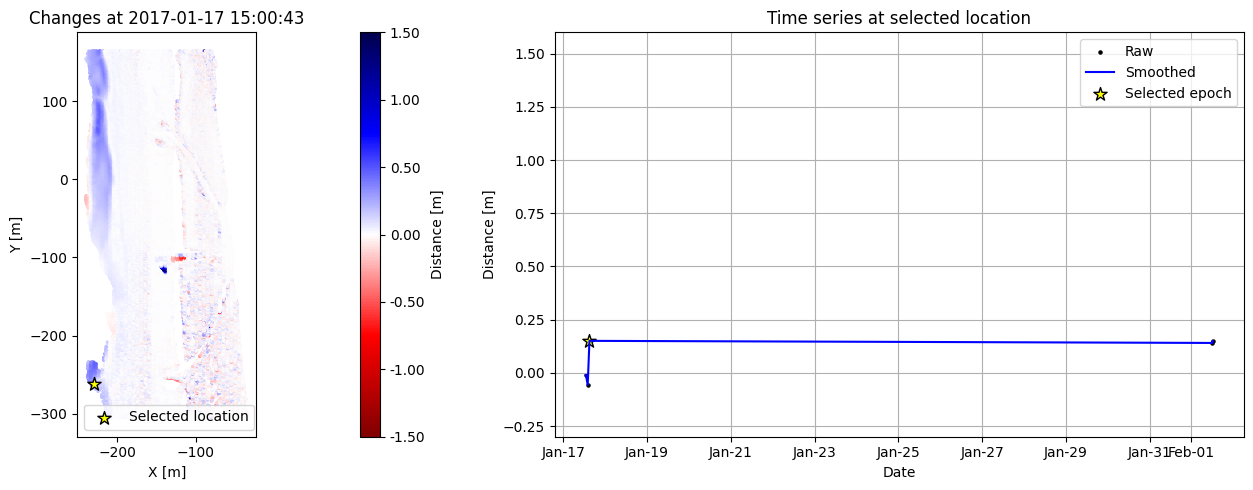

In [14]:
# demo continues

cp_idx_sel = 1273  # selected core point index
epoch_idx_sel = 2  # selected epoch index

# Import plotting module
import matplotlib.pyplot as plt

# Allow interactive rotation in notebook
%matplotlib inline

# Create the figure
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Get the corepoints
corepoints = analysis.corepoints.cloud

# get change values of last epoch for all corepoints
distances = analysis.distances
distances_epoch = [d[epoch_idx_sel] for d in distances]

# Get the time series of changes at a specific core point locations
coord_sel = analysis.corepoints.cloud[cp_idx_sel]
timeseries_sel = distances[cp_idx_sel]

# Get the list of timestamps from the reference epoch timestamp and timedeltas
timestamps = [t + analysis.reference_epoch.timestamp for t in analysis.timedeltas]

# Plot the scene
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=distances_epoch[:],
    cmap="seismic_r",
    vmin=-1.5,
    vmax=1.5,
    s=1,
    zorder=1,
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1, pad=0.15)

# Add the location of the selected coordinate
ax1.scatter(
    coord_sel[0],
    coord_sel[1],
    facecolor="yellow",
    edgecolor="black",
    s=100,
    zorder=2,
    label="Selected location",
    marker="*",
)
ax1.legend()

# Configure the plot layout
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_aspect("equal")
ax1.set_title(
    "Changes at %s"
    % (analysis.reference_epoch.timestamp + analysis.timedeltas[epoch_idx_sel])
)

# Plot the time series
ax2.scatter(timestamps, timeseries_sel, s=5, color="black", label="Raw")
ax2.plot(timestamps, timeseries_sel, color="blue", label="Smoothed")
ax2.set_xlabel("Date")

# Add the epoch of the plotted scene
ax2.scatter(
    timestamps[epoch_idx_sel],
    timeseries_sel[epoch_idx_sel],
    facecolor="yellow",
    marker="*",
    edgecolor="black",
    s=100,
    color="red",
    label="Selected epoch",
)
ax2.legend()

# Format the date labels
import matplotlib.dates as mdates

dtFmt = mdates.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(dtFmt)

# Configure the plot layout
ax2.set_ylabel("Distance [m]")
ax2.grid()
ax2.set_ylim(-0.3, 1.6)
ax2.set_title("Time series at selected location")

plt.tight_layout()
plt.show()

### Other: filtering out point clouds by date or acquisition

In [ ]:
# search only for pc's in January, without February

def date_search(catalog, start_date, end_date):
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = pd.to_datetime(end_date, utc=True)
    date_filter = [item for item in catalog.get_items(recursive = True) if item.datetime >= start_date and item.datetime <= end_date]
    dates_sorted = sorted(date_filter, key = lambda x: x.datetime)
        
    return dates_sorted


In [ ]:
search_dates = date_search(root_catalog, '2016-10-11', '2017-02-01')
total_files = []
timestamps = []

#print(f"Number of items: {len(items)}")
for item in search_dates:
    a = item.assets[asset_key]
    total_files.append((pc_dir + a.href).replace('..',''))
    b = item.datetime
    timestamps.append(b.replace(tzinfo=None))

print(total_files, timestamps)

In [ ]:
# search by metadata such as acquisition mode
def trafo_search(acq):
    matches = []
    for item in items:
        if item.properties['topo4d:acquisition_mode'] == acq:
            matches.append(item)
        
    return matches


tls_search = trafo_search('TLS')
print(tls_search)

# or just grab the reference epoch
get_reference = item.properties['topo4d:trafometa']['reference_epoch']['href']
print(get_reference)
